## Jupyter Notebook:
check a few things: how to save (Ctrl+S), how to run a code block (Caps+Enter),how to move (arrows), how to create a cell (find it yourself ! : browse the menus a bit before starting !).
Note: in jupyter, like in ipython, if you just write a variable name at the end of your code (or running cell), its value will be displayed (you do not need to write "print(myVariable)", it's enough to write "myVariable")

In [1]:
from platform import python_version
python_version()

'3.11.6'

In [2]:
python_version()
print(python_version()) #does the same as above
"some string with some value, typed into the last line of the cell"

3.11.6


'some string with some value, typed into the last line of the cell'

In [3]:
print(python_version()) #does the same as above
python_version()

3.11.6


'3.11.6'

In [4]:
# ### this is useful only if you unfortunately run suing python2. If you run python3, these lines are effect-less.
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

# Goal of the tutorial:

The aim of this tutorial is to implement the Naive Bayesian calssifier on the MNIST image data set. (optionally, also on the 20newsgroups text data set).

Let's begin with MNIST. It's in the GDrive, and may be accessed "locally" at: 
https://www.lri.fr/~flandes/share/ 
    
MNIST contains images (observations, inputs) of single hand-written digits and the corresponding classes (labels, Ground Truth). 
So it is a 10-classes classification problem (0 to 9).


## Loading the data

In [14]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split

data = np.load('mnist70.npz', 'X', 'y')
X = data['X']
y = data['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

train_set = [X_train, y_train]
test_set  = [X_test,  y_test]

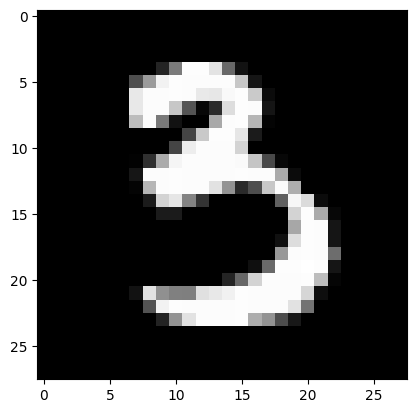

In [15]:
plt.imshow(X_train[0].reshape(28,28) , matplotlib.pyplot.cm.gray)

## Content of data

Images are stored as numpy arrays, where each line is an image, i.e. a 784-rows vector (28x28=784). Each pixel encodes a Grey value between 0 and 1.
* What do train_set, valid_set, test_set contain ? (size, type, ... )
* Write a function binarize_image(image, threshold) with a default threshold=0.5 to project an image onto binary pixels (black&white intead of grey levels)
* Try various thresholds and look for differences.

In [31]:
def binarize_image(image, threshold=0.5):
    binarized_image = image.copy()

    threshold       = np.mean(image)
    binarized_image = binarized_image > threshold
    
    return binarized_image

def batch_binarize_images(images, threshold=0.5):
    binarized_images = images.copy()

    thresholds       = np.mean(images, axis=1)
    thresholds       = np.repeat(np.expand_dims(thresholds, 1), images.shape[1], 1)
    binarized_images = binarized_images > thresholds
    
    return binarized_images

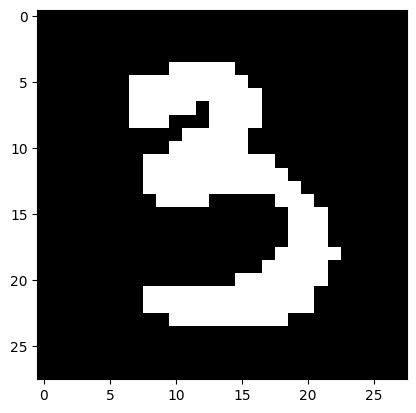

In [32]:
plt.imshow(binarize_image(X_train[0]).reshape(28,28) , matplotlib.pyplot.cm.gray)

## Getting to know the data
Here are a few examples

In [33]:
# getting images and their labels
images = train_set[0]
labels = train_set[1]
images_test = test_set[0]
labels_test = test_set[1]
print("shape d'images  :"+str(images.shape))
print("shape de labels :"+str(labels.shape))
# values
print("val. max  ", images.max())
print("val. min  ", images.min())
print("val. mean ", images.mean())
print("val. var  ", images.var())


# how many images represent the digit "5" ?
print("Nombre d'images dont le label est 5 :"+str((labels==5).sum()))
# labels==5 returns an ndarray of same dimensionality as labels but filled with booleans.
# if the label is 5, True (1), else, False (0).
# On peut se servir de cet ndarray pour faire du slicing de images
fives = (images[labels==5])
print("fives contains all images of which the label is 5, there number is:"+str(fives.shape))


shape d'images  :(46900, 784)
shape de labels :(46900,)
val. max   0.99609375
val. min   0.0
val. mean  0.13060701
val. var   0.09453307
Nombre d'images dont le label est 5 :4206
fives contains all images of which the label is 5, there number is:(4206, 784)


## Naive Bayesian (model chosen: Bernoulli)
Observations (images) are initially continuous. We need to project these data onto the space accessible to our model. In the case of Bernoulli, each pixel can only be 0 or 1 (intermediate values cannot be sampled from a Bernoulli law).

### pre-processing (of the data -what else?)

- Apply the thresholding operation to all *train* and *test* data. (it may take ~O(1) minute: try your function on test images, they are fewer)
- Check it on a couple of images.


In [36]:
bianrize_test_images  = batch_binarize_images(images_test)
bianrize_train_images = batch_binarize_images(images)

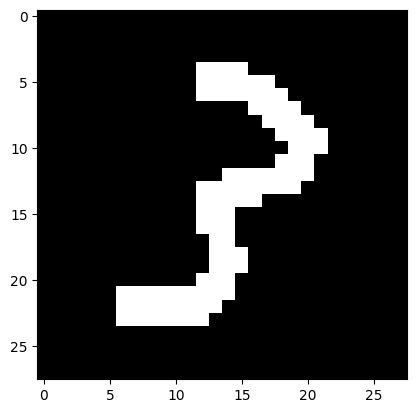

In [37]:
plt.imshow(bianrize_test_images[10].reshape(28,28) , matplotlib.pyplot.cm.gray)

## Implementing the Naive Bayesian, Bernoulli

To implement this classifier, there are only two steps:
- estimating parameters $\theta$ (including the prior probability for each class).
- inference itself:
    - knowing the parameters, return the posterior probability of classes
    - (for each image) infer the class (given the model, and this image' data)


To-do list:
Before coding, **pen and paper** !
- Which are the parameters $\theta$? Define them precisely.
- Write down the exact equations for each step; ideally, down to the pixel level.

If you don't know how to start, start with the end: write down the probability P(y|X) (see your lecture notes)


Now that **you know exactly what you want**, write down the functions needed.

Check them at several stages: 
- represent the parameters as images or graphs, (choose adequately)
- check your prediction on a couple of examples (not just 1 !!)

In [60]:
## extract the parameters (those associated to each class, which are essentially "representatives")
def get_bernouilli_params(X, y):
    unique_labels = np.sort(np.unique(y))
    p_kd = np.zeros((len(unique_labels), X.shape[1]))
    
    for k in unique_labels:
        p_kd[k, :] = np.mean(X[y == k, ], axis=0)
        
    return p_kd

p_kd = get_bernouilli_params(bianrize_train_images, labels)

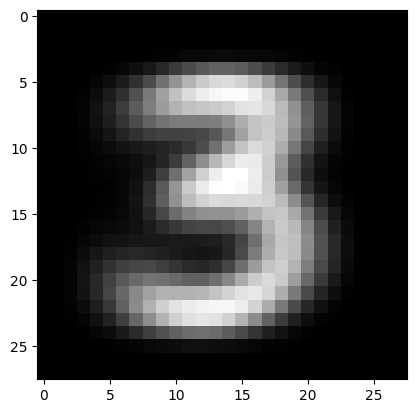

In [59]:
plt.imshow(p_kd[3].reshape(28,28), matplotlib.pyplot.cm.gray)

In [66]:
## compute the priors (for each class)
def get_priors(y):
    unique_labels = np.sort(np.unique(y))
    priors = np.array([np.sum(y == k) for k in unique_labels])
    priors = priors/np.sum(priors)
    return priors

priors = get_priors(labels)

[-368.66132768 -536.42428494 -317.95968728 -292.54923193 -339.68844111
 -269.34316111 -465.46724832 -446.95215934 -212.69696904 -405.66031567]
8


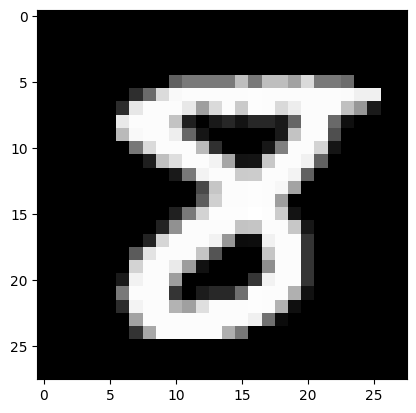

In [69]:
## make a function that computes the posterior, for a given image
# trick: when computing log(p), one should type log(1+epsilon), to avoid float overflow errors (when p~0)
def computePosteriors(image, epsilon=1e-5):
    NLABELS = len(priors)
    
    posteriors = np.array([
          np.dot(    image, np.log(    p_kd[k, :] + epsilon))
        + np.dot(1 - image, np.log(1 - p_kd[k, :] + epsilon))
        + priors[k]
            for k in range(NLABELS)
        ])
    
    return posteriors

posteriors = computePosteriors(bianrize_test_images[0])
print(posteriors)
print(np.argmax(posteriors))
plt.imshow(images_test[0].reshape(28,28), matplotlib.pyplot.cm.gray)

### [option 1: apply your function to all the train/test data]

In [73]:
def makePrediction(images):
    N = images.shape[0]
    prediction = np.zeros(N, dtype=int)
    for i in range(N):
        posteriors    = computePosteriors(images[i], epsilon=1e-5)
        prediction[i] = np.argmax(posteriors)
    return prediction

prediction_test = makePrediction(bianrize_test_images)

In [74]:
accuracy = np.mean(prediction_test == labels_test)
print(accuracy)

0.8363203463203464


### [option 2: re-write your function in a more pythonic way, handling all images at once]

In [81]:
posteriorsAllImages = computePosteriors(bianrize_test_images)
prediction_test = np.argmax(posteriorsAllImages, axis=0)

In [83]:
accuracy = np.mean(prediction_test == labels_test)
print(accuracy)

0.8363203463203464


note: 

at this point, you should have two arrays, *prediction_test_data* and *prediction_train*

## evaluation of the quality of the classifier
evaluate the classifier on the test data:
- compute the error rate
- show the confusion matrix


In [ ]:
#confusion = np.zeros((10,10))
## showing the confusion matrix with a color map ("heat map")
import pylab as pl
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion)
pl.title('Confusion matrix of the classifier')
fig.colorbar(cax)
pl.xlabel('True')
pl.ylabel('Pred.')
pl.show()

## checking using SciKit-learn

We're going to check results by cmparing with SKlearn's implementation' output.
- reproduce the experiment, using 
- try also with a Gaussian model (still Naive Bayes, but Gaussian instead of Bernoulli, still in SKlearn)

In [ ]:
## TODO: choose which class you want to use from the package sklearn.naive_bayes
from sklearn.naive_bayes import ## TODO 
## note: for a Gaussian model, use the data BEFORE binarization.